## Motivation



To people who are interested in property investment, Beijing's housing market is intriguing. With the average rental price <a href="https://www.independent.co.uk/news/business/news/beijing-named-most-expensive-global-city-to-rent-in-a6996961.html">1.2 times</a> more than average monthly wages. Purchasing a house is even more unsustainable, 48 times more than income as we can see from the graph below.
 
 <img src="BJ_NY.png">


While housing data in California or Boston is frequently used in machine learning problems, I haven’t seen an analysis on Beijing housing market. I think it would be a great chance to use some similar techniques and to understand a foreign market and see if there are any interesting insights that are due to the differences in culture and policies.

Furthermore, we can build a model to predict the housing price in Beijing. This adds more value to investors, realtors and homeowners to see if a property is underselling or overselling, and to make informed decisions.

## Data Source

The dataset is available on <a href="https://www.kaggle.com/ruiqurm/lianjia">Kaggle</a> and contains data scraped from Lianjia.com, an online housing trading platform that is both used by private persons and realtors.

It contains 318,853 rows and 26 columns.
Based on the Kaggle description,the columns are:
<ul>
<li> url: the url which fetches the data</li>
<li> id: the id of transaction</li>
<li> Lng: and Lat coordinates, using the BD09 protocol.</li>
<li> Cid: community id</li>
<li> tradeTime: the time of transaction</li>
<li> DOM: active days on market. (know more on https://en.wikipedia.org/wiki/Days_on_market)</li>
<li> followers: the number of people follow the transaction.</li>
<li> totalPrice: the total price</li>
<li> price: the average price by square</li>
<li> square: the square of house</li>
<li> livingRoom: the number of living room</li>
<li> drawingRoom: the number of drawing room</li>
<li> kitchen: the number of kitchen</li>
<li> bathroom the number of bathroom</li>
<li> floor: the height of the house.</li>
<li> buildingType: including tower(1) , bungalow(2)，combination of plate and tower(3),  plate(4).</li>
<li> constructionTime: the time of construction</li>
<li> renovationCondition: including other(1), rough(2),Simplicity(3), hardcover(4)</li>
<li> buildingStructure: including unknow(1), mixed(2), brick and wood (3), brick and  concrete( 4 ),steel( 5 ) and steel-concrete composite ( 6 ).</li>
<li>ladderRatio: the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on average</li>
<li>elevator have ( 1 ) or not have elevator( 0 )</li>
<li>fiveYearsProperty: if the owner have the property for less than 5 years</li>
<ul/>


## Analysis Overview

In [3]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

## Data ingesting and cleaning

In [26]:
df_original = pd.read_csv("new.csv",encoding='latin1')

In [27]:
# dropping identifiers like ID, cID, url
# dropping DOM because it contains mostly null values
columns_to_pick = ['Lng', 'Lat', 
        'followers', 'tradeTime',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'floor', 'buildingType', 'constructionTime',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'district', 'communityAverage']
df = df_original[columns_to_pick]

In [28]:
df.sample(10)['floor']

165384     ÖÐ 5
158093    µÍ 10
82300     ¶¥ 11
269856     µ× 6
72485      ¸ß 6
117452     ¸ß 7
240549    µÍ 16
255305    ÖÐ 13
172336    ¸ß 15
12500      ÖÐ 6
Name: floor, dtype: object

In [29]:
# convert tradeTime to datetime
df['tradeTime'] = pd.to_datetime(df['tradeTime'])
# extract floor from the garbled text
df['floor'] = df['floor'].apply(lambda x: (x.split(' ')[-1]))
    
# remove garbled textfields in the following cols
digit_cols = ['livingRoom', 'drawingRoom', 'kitchen','bathRoom', 'floor', 'constructionTime'] 
    
for s in digit_cols:
    df = df[df[s].apply(lambda v:str(v).isdigit())]
    df[s] = df[s].astype('int')

In [36]:
# total price is in 10000 RMB, price is in RMB
# convert price and total price 1 RMB = 6.76 USD
df['price'] = df['price']/6.76
df['totalPrice'] = df['totalPrice'] * 10000 / 6.76

In [30]:
print ('Starting with', len(df) , 'rows')
print ('Cleaning... ')
df = df.dropna()
print ('Ending with:', len(df), 'rows')

Starting with 299536 rows
Cleaning... 
Ending with: 297701 rows


followers


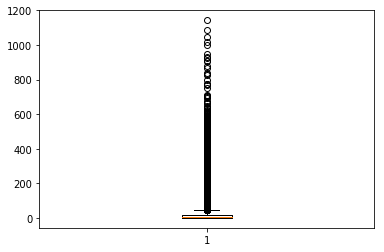

totalPrice


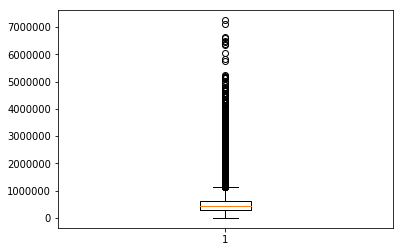

price


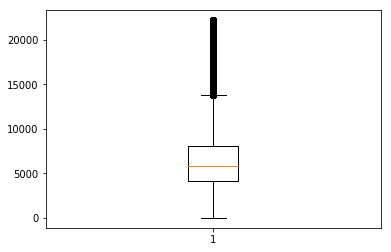

square


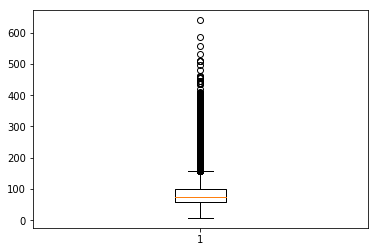

floor


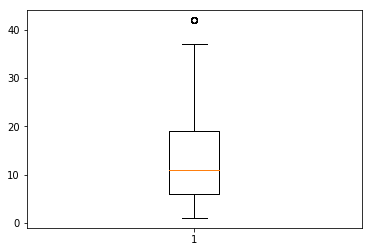

constructionTime


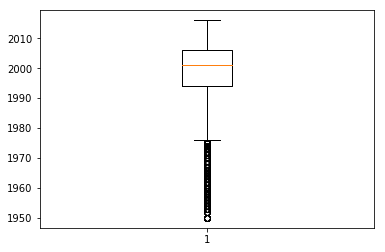

livingRoom


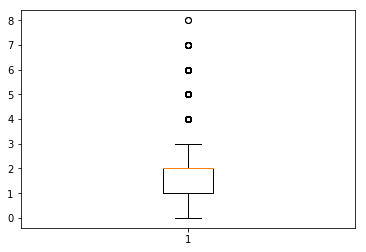

drawingRoom


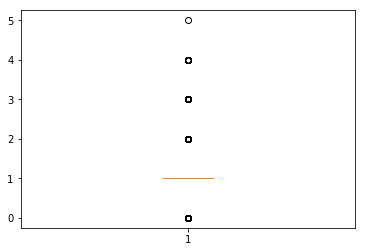

kitchen


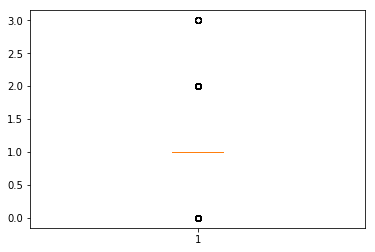

bathRoom


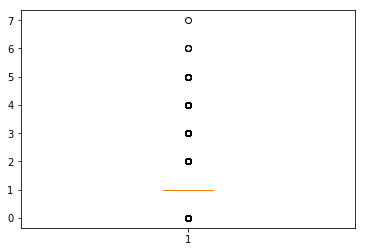

ladderRatio


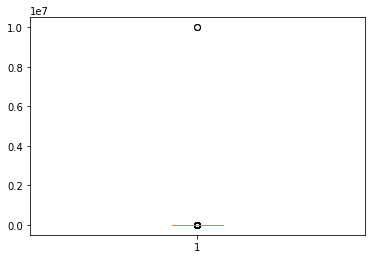

communityAverage


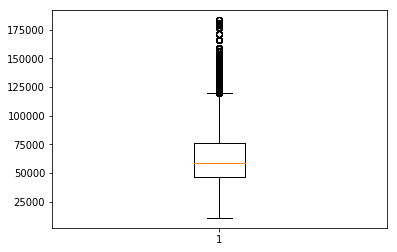

tradeTime


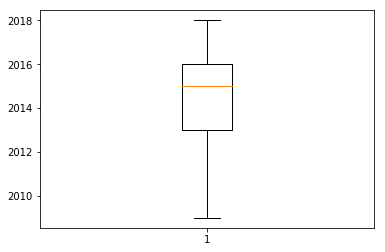

buildingType


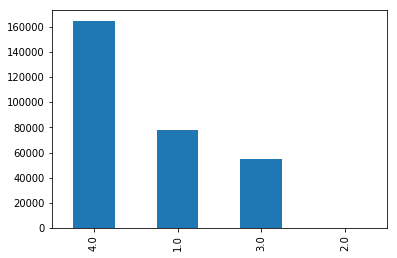



elevator


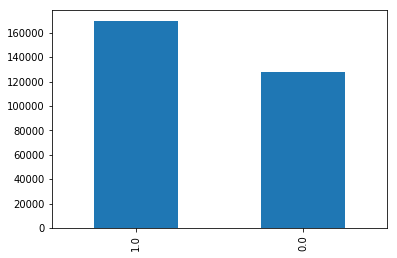



fiveYearsProperty


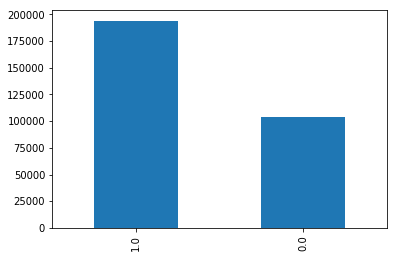



subway


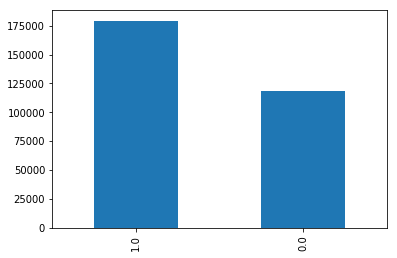



renovationCondition


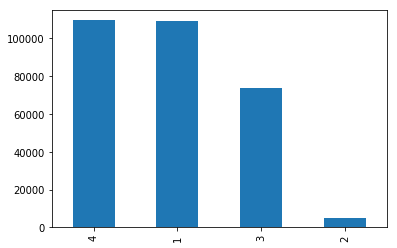



buildingStructure


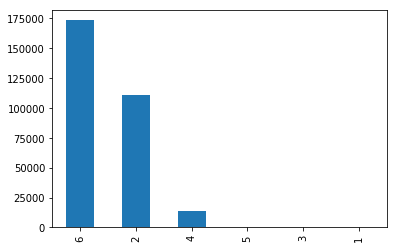



district


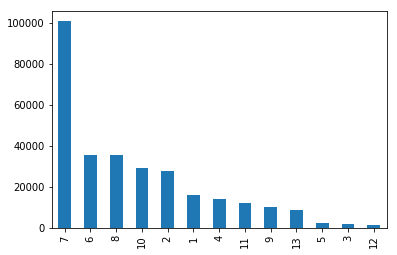

In [38]:
def visualize_outliers(df):   
    numeric_cols = ['followers','totalPrice', 'price', 'square','floor',
                    'constructionTime',
                    'livingRoom', 'drawingRoom', 'kitchen','bathRoom', 
                    'ladderRatio','communityAverage']
    date_cols = ['tradeTime']
    cat_cols = ['buildingType','elevator','fiveYearsProperty','subway',
               'renovationCondition', 'buildingStructure','district'] 
    for i in numeric_cols:
        print(i)
        plt.boxplot(df[i])
        plt.show()
    for i in date_cols:
        print(i)
        plt.boxplot(df[i].dt.year)
        plt.show()
    for i in cat_cols:
        print(i)
        #print(len(set(df[i])))
        #print(df[i].value_counts())
        df[i].value_counts().plot(kind='bar')
        plt.show()
        print("")
        print("")
visualize_outliers(df)

In [50]:
# removing outliers that are obvious in some columns 
df = df[df['tradeTime'].dt.year>2008]
df = df[df['floor']<50]
df = df[df['ladderRatio']<=1]

## EDA

### how is the total price distributed?

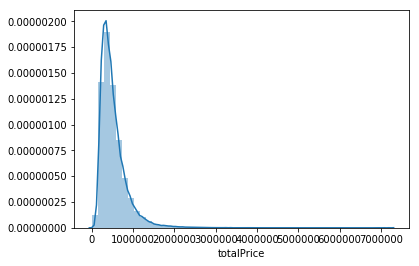

In [40]:
sns.distplot(df['totalPrice'])

In [37]:
df['totalPrice'].describe()

count    2.976940e+05
mean     5.166079e+05
std      3.321016e+05
min      1.479290e+02
25%      3.032544e+05
50%      4.363905e+05
75%      6.316568e+05
max      7.248521e+06
Name: totalPrice, dtype: float64

Accoring to PayScale.com, the current average yearly salary in Beijing is 246,827 RMB which is \\$36512. 

From out dataset, the minimum housing price is \\$147. 
The price goes up quickly - at 25 percentile the price is \\$303254 which is already roughly 10 times than the average income.

The average price is \\$516608, which is 14 times of average salary. This number is smaller than what we saw ealier in the Motivation, but 14 is a rough estimate since the dataset ranges from 2008 to now, and we ignored the housing market and interest rate fluctuations.

In [42]:
df[df['tradeTime'].dt.year>2016]['totalPrice'].describe()

count    4.222600e+04
mean     7.781231e+05
std      4.134722e+05
min      1.479290e+03
25%      5.251479e+05
50%      6.789941e+05
75%      9.097633e+05
max      7.248521e+06
Name: totalPrice, dtype: float64

Now the income ratio is 778123 / 36512 = 21 times.

### Which district is the most expensive?

followers


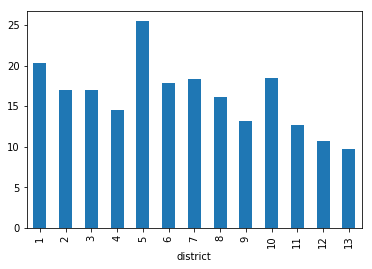

totalPrice


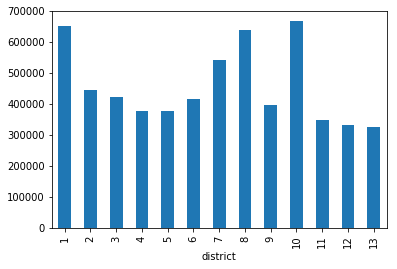

square


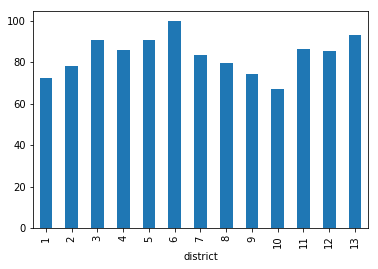

buildingType


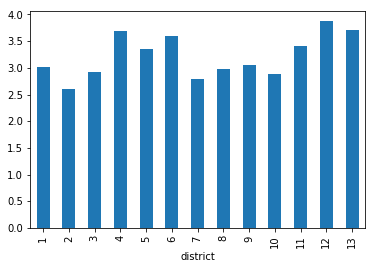

constructionTime


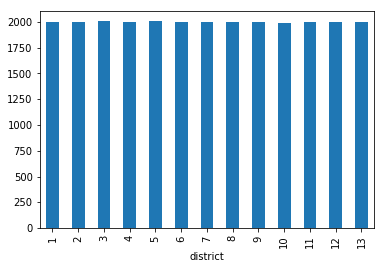

renovationCondition


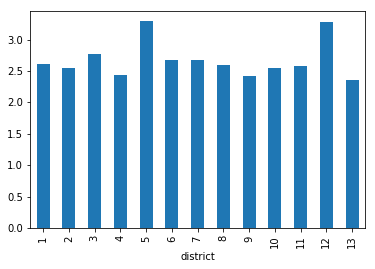

ladderRatio


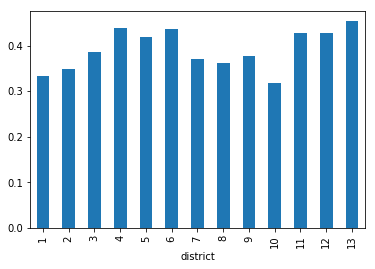

fiveYearsProperty


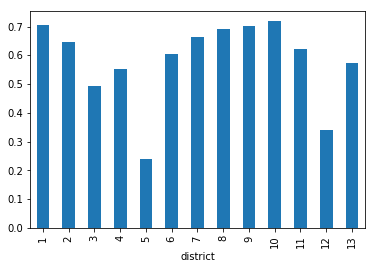

subway


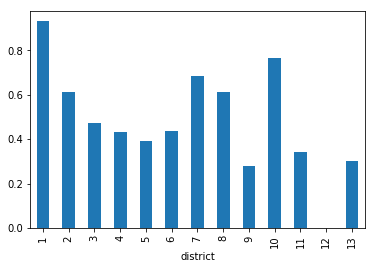

communityAverage


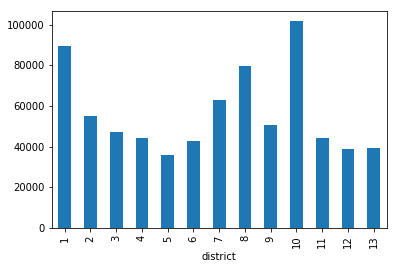

In [51]:
features = ['followers','totalPrice','square','buildingType','constructionTime',
           'renovationCondition','ladderRatio','fiveYearsProperty','subway','communityAverage']
for i in features:
    print (i)
    df.groupby('district').mean()[i].plot.bar()
    plt.show()

We see from the barplots that District 1 and 10 is the most expensive ones. They have the highest total prices and community averages.
District 1 also is the most accessible to the subway.

However, they are the smallest in squares. This tells me that these 2 district are likely to be at the city center, like financial districts.

Interestingly, district 5 has the most popular properties, many followers, decent sizes of the house, but the price is relatively low. This district is probably not as close to the city center, but is developing and good for living.

With the help of tableau, I was able to visually understand these district.
<img src = 'districtonmap 1.png'>

This map proves my thoughts about district 1, 5 and 10. District 5 is on the outskirt of the city, which maybe the reason why the properties have the larger square area and lower prices.

From our EDA, we can see the price is strongly related to several factors. 

District is definitely a telling one. 

The square area of the house, which in many housing datasets are the most telling predictors, may actually have limited power here because the most expensive houses in Beijing are smaller in size.

We can also preliminarily tell that the more the followers, the cheaper the houses.

With these rough ideas, let's dive into modeling.


## Making Prediction

For a first round modeling, I'd like to try linear regression and random forest regression to predict the prices.

In [52]:
df.columns

Index(['Lng', 'Lat', 'followers', 'tradeTime', 'totalPrice', 'price', 'square',
       'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor',
       'buildingType', 'constructionTime', 'renovationCondition',
       'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway', 'district', 'communityAverage'],
      dtype='object')

In [105]:
selected_features = ['followers','totalPrice', 'square',
       'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor',
       'buildingType', 'renovationCondition','buildingStructure', 
                     'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway', 'district', 'communityAverage']
df_ml = df[selected_features]

### transforming and scaling the data

In [121]:
def convert_categorical(df):
    '''
    this funciton coverts categorical variables in df through OHE.
    
    '''
    cat_var = [
        'buildingType', 
        'livingRoom',
       'drawingRoom', 'kitchen', 'bathRoom', 
       'renovationCondition', 
        'buildingStructure', 
        'district']
    for i in cat_var:
        df[i] = df[i].astype('category')
    df = pd.get_dummies(data = df,columns = cat_var)
    return df
df_ml = convert_categorical(df_ml)

In [122]:
selected_features = df_ml.columns.tolist()
selected_features.remove('totalPrice')
selected_features

['followers',
 'square',
 'floor',
 'ladderRatio',
 'elevator',
 'fiveYearsProperty',
 'subway',
 'communityAverage',
 'buildingType_1.0',
 'buildingType_2.0',
 'buildingType_3.0',
 'buildingType_4.0',
 'livingRoom_0',
 'livingRoom_1',
 'livingRoom_2',
 'livingRoom_3',
 'livingRoom_4',
 'livingRoom_5',
 'livingRoom_6',
 'livingRoom_7',
 'livingRoom_8',
 'drawingRoom_0',
 'drawingRoom_1',
 'drawingRoom_2',
 'drawingRoom_3',
 'drawingRoom_4',
 'drawingRoom_5',
 'kitchen_0',
 'kitchen_1',
 'kitchen_2',
 'kitchen_3',
 'bathRoom_0',
 'bathRoom_1',
 'bathRoom_2',
 'bathRoom_3',
 'bathRoom_4',
 'bathRoom_5',
 'bathRoom_6',
 'bathRoom_7',
 'renovationCondition_1',
 'renovationCondition_2',
 'renovationCondition_3',
 'renovationCondition_4',
 'buildingStructure_1',
 'buildingStructure_2',
 'buildingStructure_3',
 'buildingStructure_4',
 'buildingStructure_5',
 'buildingStructure_6',
 'district_1',
 'district_2',
 'district_3',
 'district_4',
 'district_5',
 'district_6',
 'district_7',
 'distri

In [92]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
df_ml = min_max_scaler.fit_transform(df_ml)

In [93]:
y = pd.DataFrame(df_ml).iloc[:,1]
X = pd.DataFrame(df_ml).drop([1],axis = 1)

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from math import sqrt

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [95]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

l1_regression = linear_model.Lasso()
l2_regression = linear_model.Ridge()
rfr = RandomForestRegressor()

modellist = []
modellist.append(l1_regression)
modellist.append(l2_regression)
modellist.append(rfr)

In [99]:
best_model = None
best_score = np.inf
for i in modellist:
    print(i)
    i.fit(X_train.values,y_train)
    y_predict = i.predict(X_test.values)
    score = sqrt(mean_squared_error(y_test,y_predict))
    print('score = ', score)
    if score < best_score:
        best_score = score
        best_model = i
    print()
    print()
    print()

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
score =  0.045715836575981376



Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
score =  0.025838505541403652



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
score =  0.021638180273853384





### Top 10 predictors

In [123]:

important_feature_idx = np.argsort(best_model.feature_importances_)[::-1][:10]

for i in important_feature_idx:
    print (selected_features[i],best_model.feature_importances_[i])
    


square 0.4182528882057608
communityAverage 0.32713655384657414
followers 0.10422403848419433
renovationCondition_1 0.043876397768107894
floor 0.020628479747999535
ladderRatio 0.015437567025848555
fiveYearsProperty 0.01106735904487509
subway 0.003998754322925571
renovationCondition_4 0.0034269838069980753
drawingRoom_1 0.002972656180983097


## Interpretation and Future Step

We can see square is still very predictive in this dataset. Other top 5 important factors are communityAverage, followers,renovationCondition_1.0, and ladderRatio.

Future work on this model includes:

1)
    test on the time-stability on this model, and incorporate inflation and currency fluctuation factors.
2)
    feature engineer.

3)
     hyperparmeter selection on random forest.